In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    precision_recall_curve, 
    average_precision_score, 
    roc_auc_score, 
    confusion_matrix
)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
df = pd.read_csv('../data/token_datasets.csv')

print(f"Loaded dataset with {df.shape[0]} samples and {df.shape[1]} features.")
df.head()

Loaded dataset with 338 samples and 46 features.


,mint,signal_source,grade,checked_at_utc,checked_at_timestamp,time_of_day_utc,day_of_week_utc,is_weekend_utc,is_public_holiday_any,price_usd,...,creator_dumped,pump_dump_risk_score,hour_category,is_last_day_of_week,label_status,label_ath_roi,label_final_roi,label_hit_50_percent,label_token_age_hours,label_tracking_duration_hours
0,ALR5X2H6THn2VDPoMtkVwxVktcN1kQGvxCwLfejzpump,alpha,LOW,2025-10-24 07:14:28.489645+00:00,1761290068,7,4,0,0,0.000870,...,False,15.0,asia_hours,True,loss,0.000000,-36.732690,0,1009.03,168
1,FL4eKdJrVZ1dVu1RoekeQRnuPxavzD4oCcR5HTcspump,alpha,LOW,2025-10-24 07:27:05.654068+00:00,1761290825,7,4,0,0,0.000656,...,False,15.0,asia_hours,True,loss,0.000000,-85.643540,0,374.79,168
2,CA6DpicXuJUsSWziuV4oHmqpHTSMZLz9EGjYPyXJpump,alpha,LOW,2025-10-24 07:45:00.633975+00:00,1761291900,7,4,0,0,0.000353,...,False,15.0,asia_hours,True,loss,0.000000,-95.962964,0,512.17,168
3,6H8uyJYrPVcra6Fi7iWh29DXSm8KctzhHRyXmPwKpump,alpha,LOW,2025-10-24 07:49:04.765887+00:00,1761292144,7,4,0,0,0.000399,...,False,0.0,asia_hours,True,win,91.465226,45.701797,1,706.13,336
4,HfPXryJcby5h6uxGVs6vVFJTcmGpPTnRRdMGManUpump,alpha,LOW,2025-10-24 07:49:17.010655+00:00,1761292157,7,4,0,0,0.000122,...,False,0.0,asia_hours,True,loss,0.000000,-94.039661,0,480.08,168


In [15]:
# Create the binary target variable 'target'
df['target'] = (df['label_status'] == 'win').astype(int)

# Check the distribution of our target
print("Target variable distribution:")
print(df['target'].value_counts(normalize=True))

# This is our "Baseline"
print(f"\nBaseline Accuracy (always guessing 'Win'): {df['target'].mean():.2%}")

Target variable distribution:
target
1    0.633136
0    0.366864
Name: proportion, dtype: float64

Baseline Accuracy (always guessing 'Win'): 63.31%


Analyzing 'token_age_hours_at_signal'...

Win Rate by Age Bracket:
                 mean  count
age_bracket                 
12-24h       1.000000      4
48-72h       1.000000      1
72h+         0.857143     21
24-48h       0.833333      6
0-6h         0.608696    299
6-12h        0.571429      7


C:\Users\HP USER\AppData\Local\Temp\ipykernel_13244\3997507158.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=age_analysis.index, y=age_analysis['mean'], palette="viridis")


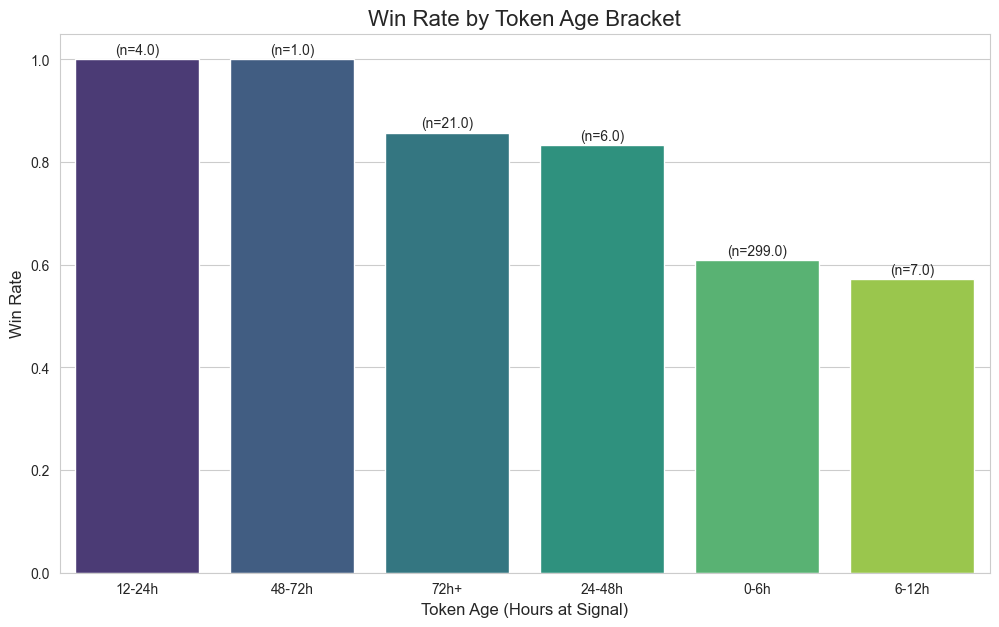

In [16]:
print("Analyzing 'token_age_hours_at_signal'...")

# Handle missing or invalid values just in case
df['token_age_hours_at_signal'] = pd.to_numeric(df['token_age_hours_at_signal'], errors='coerce').fillna(0)

# Create age brackets
age_bins = [0, 6, 12, 24, 48, 72, np.inf]
age_labels = ['0-6h', '6-12h', '12-24h', '24-48h', '48-72h', '72h+']
df['age_bracket'] = pd.cut(df['token_age_hours_at_signal'], bins=age_bins, labels=age_labels, right=False)

# Handle tokens with 0 age
df['age_bracket'] = df['age_bracket'].astype(str).replace('nan', '0-6h')

# Calculate win rate per bracket
age_analysis = df.groupby('age_bracket')['target'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

print("\nWin Rate by Age Bracket:")
print(age_analysis)

# Plot the results
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=age_analysis.index, y=age_analysis['mean'], palette="viridis")
ax.set_title('Win Rate by Token Age Bracket', fontsize=16)
ax.set_xlabel('Token Age (Hours at Signal)', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)

# Add (n=count) labels
for i, (index, row) in enumerate(age_analysis.iterrows()):
    ax.text(i, row['mean'] + 0.01, f"(n={row['count']})", ha='center', fontsize=10)

# Save the plot
plt.savefig('win_rate_by_age.png')

In [17]:
# Create log-transformed features
def safe_log(x):
    return np.log1p(x.clip(lower=0))

df['log_volume'] = safe_log(df['volume_h24_usd'])
df['log_liquidity'] = safe_log(df['liquidity_usd'])
df['log_fdv'] = safe_log(df['fdv_usd'])

# Define our final feature set
NUMERIC_FEATURES = [
    'overlap_quality_score', 
    'pump_dump_risk_score', 
    'log_volume', 
    'price_change_h24_pct', 
    'log_liquidity', 
    'log_fdv', 
    'liquidity_usd'
]

CATEGORICAL_FEATURES = [
    'signal_source',
    'age_bracket'
]

SELECTED_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

# Separate our features (X) and target (y)
X = df[SELECTED_FEATURES]
y = df['target']

print(f"Using {len(SELECTED_FEATURES)} features for modeling.")
X.head(15)

Using 9 features for modeling.


,overlap_quality_score,pump_dump_risk_score,log_volume,price_change_h24_pct,log_liquidity,log_fdv,liquidity_usd,signal_source,age_bracket
0,0.001631,15.0,0.000000,0.00,11.808870,0.000000,134438.549151,alpha,0-6h
1,0.000245,15.0,0.000000,0.00,11.535995,0.000000,102332.785776,alpha,0-6h
2,0.000817,15.0,0.000000,0.00,11.220882,0.000000,74672.610281,alpha,0-6h
3,0.000741,0.0,0.000000,0.00,11.309698,0.000000,81608.278549,alpha,0-6h
4,0.000847,0.0,0.000000,0.00,10.715944,0.000000,45067.733988,alpha,0-6h
5,0.018395,38.0,14.768937,-81.07,10.697115,11.717832,44227.090000,alpha,24-48h
6,0.000150,45.0,14.476508,-30.37,10.075093,10.571804,23743.180000,alpha,24-48h
7,0.010885,15.0,0.000000,0.00,10.276597,0.000000,29043.853837,alpha,0-6h
8,0.018256,8.0,0.000000,0.00,10.961879,0.000000,57633.613929,alpha,0-6h
9,0.000237,8.0,0.000000,0.00,11.010331,0.000000,60494.881059,alpha,0-6h


In [23]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% for testing
    random_state=42,  # For reproducible results
    stratify=y        # Critical for imbalanced datasets
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples:     {len(X_test)}")
print(f"Test win rate:    {y_test.mean():.2%}")
print(f"Train win rate:   {y_train.mean():.2%}")

Training samples: 270
Test samples:     68
Test win rate:    63.24%
Train win rate:   63.33%


In [19]:
# Create a preprocessing pipeline for numeric features (scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a preprocessing pipeline for categorical features (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine these steps in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ])

# Create the full model pipeline
# We add class_weight='balanced' to help with the imbalanced data
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced', 
        solver='liblinear', 
        random_state=42
    ))
])

# Now, we train the entire pipeline on our training data
print("Training the model...")
model.fit(X_train, y_train)
print("Training complete!")

Training the model...
Training complete!


In [24]:
# Get predicted probabilities (for curves)
y_pred_probs = model.predict_proba(X_test)[:, 1]

# Get standard predictions (at 0.5 threshold)
y_pred_default = model.predict(X_test)

print("--- Evaluation on Test Set (Default 0.5 Threshold) ---")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default, target_names=['Loss', 'Win']))

# Print our key metrics
print(f"ROC AUC Score:            {roc_auc_score(y_test, y_pred_probs):.4f}")
print(f"Average Precision Score:  {average_precision_score(y_test, y_pred_probs):.4f}")

--- Evaluation on Test Set (Default 0.5 Threshold) ---

Classification Report:
              precision    recall  f1-score   support

        Loss       0.50      0.52      0.51        25
         Win       0.71      0.70      0.71        43

    accuracy                           0.63        68
   macro avg       0.61      0.61      0.61        68
weighted avg       0.64      0.63      0.63        68

ROC AUC Score:            0.7107
Average Precision Score:  0.8411


To achieve 80% Precision, we need a threshold of: 0.5238


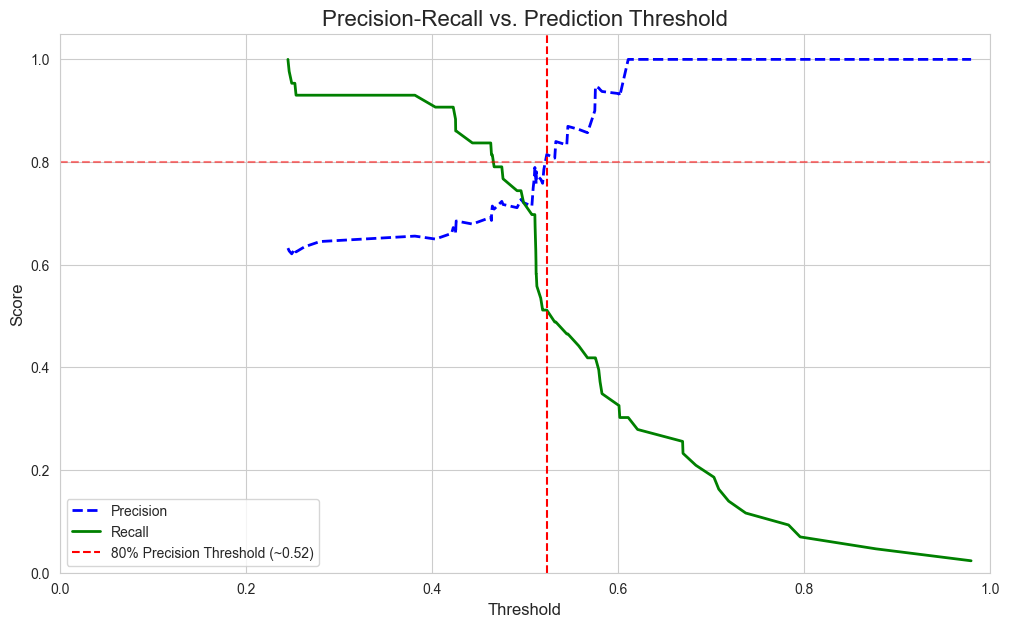

In [21]:
# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot the curves
plt.figure(figsize=(12, 7))
plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.title('Precision-Recall vs. Prediction Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='lower left', fontsize=11)
plt.ylim([0, 1.05])
plt.xlim([0, 1.0]) # Thresholds are between 0 and 1

# Find and plot the threshold for 80% precision
try:
    # Find the first threshold where precision is >= 0.80
    threshold_80_index = np.min(np.where(precision >= 0.80))
    threshold_80 = thresholds[threshold_80_index]
    
    plt.axvline(x=threshold_80, linestyle='--', color='red', 
                label=f"80% Precision Threshold (~{threshold_80:.2f})")
    plt.axhline(y=0.80, linestyle='--', color='red', alpha=0.5)
    print(f"To achieve 80% Precision, we need a threshold of: {threshold_80:.4f}")
except ValueError:
    print("Could not find a threshold for 80% precision.")

plt.legend()
plt.savefig('precision_recall_curve.png')